# 📈 TSLA LSTM Price Forecasting

In this notebook, we use a Long Short-Term Memory (LSTM) network to forecast the next-day closing price of Tesla (TSLA) stock. This model is a deep learning alternative to tree-based methods, better suited for capturing sequential dependencies in time-series data.

We'll walk through:
- Data preprocessing and scaling
- Creating rolling sequences for training
- Building and training an LSTM network
- Evaluating and visualizing the results


In [1]:
# 📦 Install dependencies
!pip install yfinance --quiet

# 📚 Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## 📥 Step 1: Load Historical TSLA Price Data

We use Yahoo Finance to download 1 year of daily closing prices for TSLA.


In [2]:
tsla = yf.download('TSLA', period='2y', interval='1d')
tsla = tsla[['Close']].dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 🔁 Step 2: Preprocess & Create Sequences

We normalize the prices using MinMaxScaler (range [0,1]) and create sliding sequences of 20 days of past prices to predict the next day.

The data will be reshaped into 3D for LSTM: `(samples, timesteps, features)`.


In [3]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tsla[['Close']])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input


## ✂️ Step 3: Split into Training and Test Sets

We'll use the first 80% of the data for training and the last 20% for testing.


In [4]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## 🧠 Step 4: Build and Train LSTM Model

We use two stacked LSTM layers with dropout for regularization, followed by a Dense layer for regression output.

The model is trained for 20 epochs with batch size 32.


In [5]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.0344
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0106
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0061
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0043
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0034
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0030
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0029
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0026
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0028
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0028
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0021
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0024
Epo

## 🔄 Step 5: Make Predictions and Inverse Scale

We use the trained model to predict on the test set, and convert the output back to the original price scale.


In [6]:
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


## 📊 Step 6: Visualize Actual vs Predicted Prices

We compare the predicted TSLA closing prices to the actual test set prices.


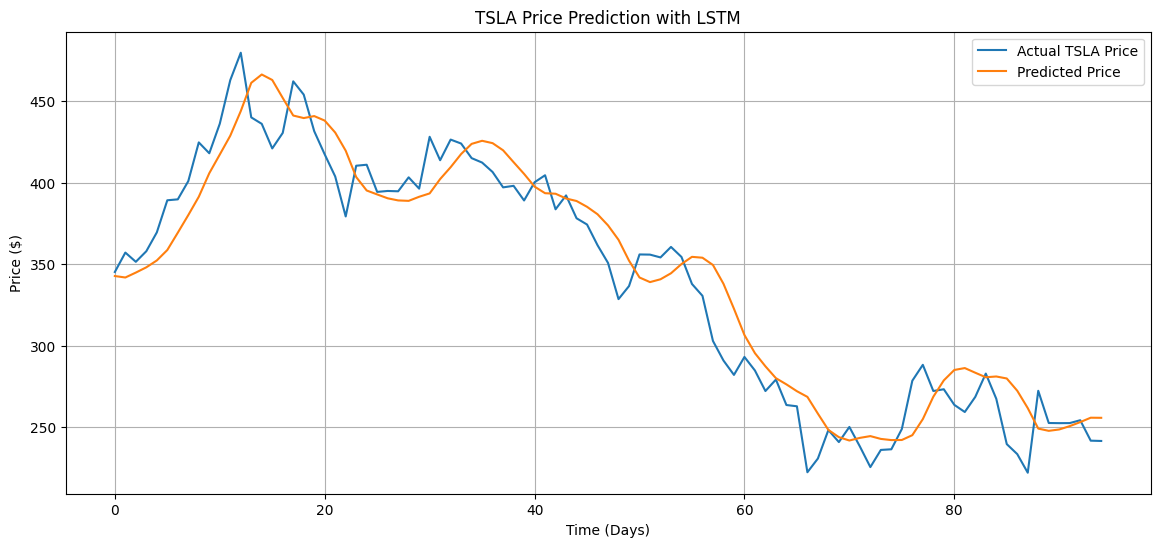

In [7]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual TSLA Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('TSLA Price Prediction with LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


## 🧪 Step 7: Evaluate the Model

We'll calculate RMSE and R² to measure how well the LSTM performs on the test set.


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📉 RMSE: 21.05
📈 R² Score: 0.9183


## 🧪 Step 8: Backtest LSTM Forecast Strategy

Now that we’ve forecasted future TSLA closing prices, we’ll simulate a trading strategy:
- If the **predicted next-day price is higher than today’s price**, we take a long position.
- Otherwise, we stay out (or in cash).

We compare this to a buy-and-hold baseline using:
- Final portfolio value
- Strategy return
- Buy & hold return
- Sharpe ratio
- Win rate


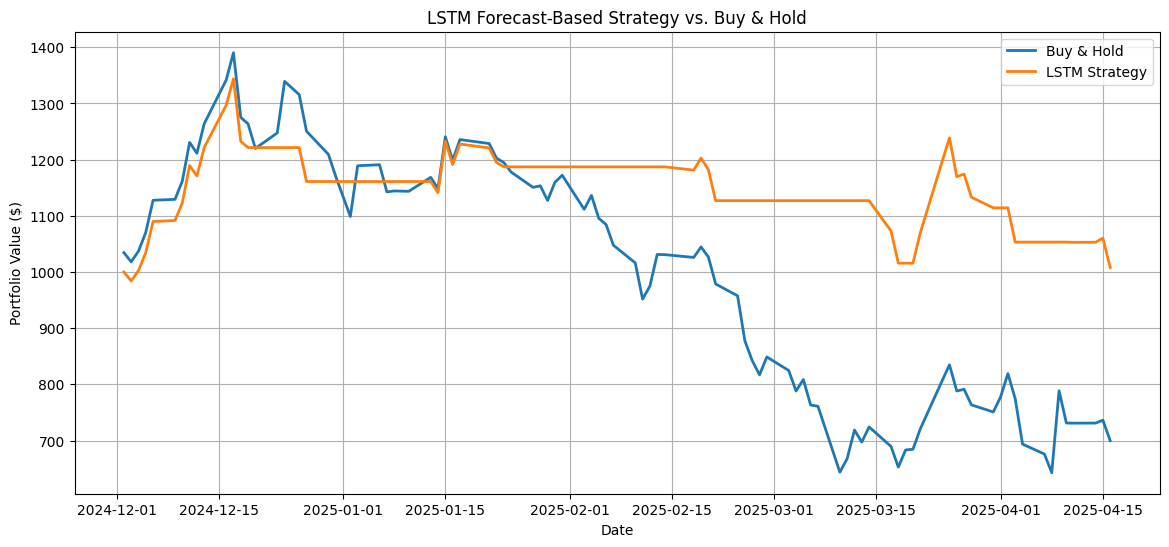


💰 Strategy Return: 0.79%
📉 Buy & Hold Return: -30.02%
📊 Win Rate: 19.35%
📈 Sharpe Ratio: 0.27


In [9]:
# 📊 LSTM Forecast-Based Trading Backtest

# === 📌 Text Cell (Put this before the code) ===
"""
## 🧪 Step 8: Backtest LSTM Forecast Strategy

Now that we’ve forecasted future TSLA closing prices, we’ll simulate a trading strategy:
- If the **predicted next-day price is higher than today’s price**, we take a long position.
- Otherwise, we stay out (or in cash).

We compare this to a buy-and-hold baseline using:
- Final portfolio value
- Strategy return
- Buy & hold return
- Sharpe ratio
- Win rate
"""

# === 📈 Backtest Code ===

# Build a DataFrame to align predictions
backtest_df = tsla.iloc[-len(predicted_prices):].copy()
backtest_df['Predicted_Price'] = predicted_prices
backtest_df['Actual_Price'] = actual_prices

# Generate position signal: 1 if predicted price tomorrow > today
backtest_df['Pred_Next'] = backtest_df['Predicted_Price'].shift(-1)
backtest_df['Position'] = (backtest_df['Pred_Next'] > backtest_df['Predicted_Price']).astype(int)

# Calculate returns
backtest_df['Market Return'] = backtest_df['Actual_Price'].pct_change()
backtest_df['Strategy Return'] = backtest_df['Market Return'] * backtest_df['Position'].shift(1)

# Drop NAs
backtest_df.dropna(inplace=True)

# Equity curves
initial_cash = 1000
market_curve = (1 + backtest_df['Market Return']).cumprod() * initial_cash
strategy_curve = (1 + backtest_df['Strategy Return']).cumprod() * initial_cash

# Plot equity curves
plt.figure(figsize=(14,6))
plt.plot(market_curve, label='Buy & Hold', linewidth=2)
plt.plot(strategy_curve, label='LSTM Strategy', linewidth=2)
plt.title('LSTM Forecast-Based Strategy vs. Buy & Hold')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# Performance metrics
from numpy import sqrt, mean, std
strategy_return = strategy_curve.iloc[-1] / initial_cash - 1
buyhold_return = market_curve.iloc[-1] / initial_cash - 1
win_rate = (backtest_df['Strategy Return'] > 0).mean()
sharpe = mean(backtest_df['Strategy Return']) / std(backtest_df['Strategy Return']) * sqrt(252)

print(f"\n💰 Strategy Return: {strategy_return:.2%}")
print(f"📉 Buy & Hold Return: {buyhold_return:.2%}")
print(f"📊 Win Rate: {win_rate:.2%}")
print(f"📈 Sharpe Ratio: {sharpe:.2f}")
